In [1]:
import warnings
warnings.filterwarnings('ignore')
# import tensorflow as tf
# print(tf.__version__)
# print("GPU: ", tf.test.gpu_device_name())
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## **Drive Mount**

In [2]:
from google.colab import drive
# drive.flush_and_unmount()
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## **Imports**

In [0]:
import os
import numpy as np

from keras.models import Sequential, load_model
from keras.layers import LSTM, Dropout, Dense, TimeDistributed, Activation, CuDNNLSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras.optimizers import Adam, RMSprop

## **Project Level Contants**

In [0]:
PROJECT_DIR = '/content/gdrive/My Drive/MS_Project'
OUTPUT_DIR = '/content/gdrive/My Drive/MS_Project/Char_Level'

if not os.path.exists(PROJECT_DIR):
    os.path.mkdir(PROJECT_DIR)

if not os.path.exists(OUTPUT_DIR):
    os.path.mkdir(OUTPUT_DIR)

INPUT_FILE = 'LOR_full.txt'

In [40]:
HIDDEN_UNITS = 512
HIDDEN_LAYERS = 3

LOAD_PRETRAINED_MODEL = False

WEIGHTS_FILE = INPUT_FILE.split('.')[0] + '_' + str(HIDDEN_UNITS) + 'U_' + str(HIDDEN_LAYERS) + 'L'
WEIGHTS_FILE += '_checkpoint.h5'
print(WEIGHTS_FILE)

LOR_full_700U_3L_checkpoint.h5


## **Preprocessing**

In [38]:
input_file_path = os.path.join(PROJECT_DIR, INPUT_FILE)

with open(input_file_path, 'r', encoding='utf-8') as f:
    raw_text = f.read()

raw_text = raw_text.strip()
filter_chars = '®=\\^*/(){}_-\"“”'
# raw_text = ''.join(filter(lambda x: x not in filter_chars, raw_text))



filter_table = raw_text.maketrans(filter_chars, ' '*len(filter_chars))
raw_text = raw_text.translate(filter_table)

print(raw_text[:100])

unique_chars = sorted(set(raw_text))
n_features = n_uniq_chars = len(unique_chars)
print(n_uniq_chars, unique_chars)


char_index = {}
index_char = {}
for idx, char in enumerate(unique_chars):
    char_index[char] = idx
    index_char[idx] = char


 THE LORD OF THE RINGS' 

V art One 

THE FELLOWSHIP 
OF THE RING 

J.R.R.ToIkien 



Complete Table
73 ['\n', ' ', '!', "'", ',', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '—', '’']


In [39]:
max_len_seq = 60
n_datapoints = len(raw_text)//max_len_seq

data = np.zeros((n_datapoints, max_len_seq, n_uniq_chars))
labels = np.zeros((n_datapoints, max_len_seq, n_uniq_chars))

for i in range(n_datapoints):
    input_sentence = raw_text[i*max_len_seq: (i+1)*max_len_seq]
    input_seq = [char_index[char] for char in input_sentence]
    one_hot_input = np.zeros((max_len_seq, n_uniq_chars))
    for j in range(len(input_seq)):
        one_hot_input[j][input_seq[j]] = 1
    
    data[i] = one_hot_input

    target_sentence = raw_text[i*max_len_seq + 1: (i+1)*max_len_seq + 1]
    target_seq = [char_index[char] for char in target_sentence]
    one_hot_target = np.zeros((max_len_seq, n_uniq_chars))

    for j in range(len(target_seq)):
        one_hot_target[j][target_seq[j]] = 1
    
    labels[i] = one_hot_target


print(data.shape, data[:1])
print(labels.shape, labels[:1])



(42973, 60, 73) [[[0. 1. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
(42973, 60, 73) [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]]]


## **Train and Test Split**

In [50]:
from sklearn.model_selection import train_test_split


# create train and validation sets
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.1, random_state=42)

print('Train shape:', train_data.shape, 'Val shape:', test_data.shape)

Train shape: (38675, 60, 73) Val shape: (4298, 60, 73)


## **Load Pretrained Model**

In [0]:
if LOAD_PRETRAINED_MODEL:
    weight_file_path = os.path.join(OUTPUT_DIR, WEIGHTS_FILE)
    if os.path.exists(weight_file_path):
    model = load_model(weight_file_path)
    print('Model Loaded')
    else:
    print('Model Does not exist')

## **Model**

#### Perplexity

In [0]:
import keras.backend as K
def perplexity(y_true, y_pred):
    cross_entropy = K.categorical_crossentropy(y_true, y_pred)
    perplexity = K.exp( cross_entropy)
    return perplexity

In [54]:
if not LOAD_PRETRAINED_MODEL:
    print('Building New Model...')
    model = Sequential()
    model.add(CuDNNLSTM(HIDDEN_UNITS, input_shape=(None, n_uniq_chars), return_sequences=True))
    model.add(Dropout(0.5))

    for _ in range(HIDDEN_LAYERS - 1):
        model.add(CuDNNLSTM(HIDDEN_UNITS, return_sequences=True))
        model.add(Dropout(0.5))

    model.add(TimeDistributed(Dense(n_uniq_chars)))
    model.add(Activation('softmax'))
    print(model.summary())

    optimizer = Adam(lr=0.001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', 
                  metrics=[perplexity, 'acc'])
else:
    print('Model already loaded')
    print(model.summary())

Building New Model
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_13 (CuDNNLSTM)    (None, None, 700)         2170000   
_________________________________________________________________
dropout_9 (Dropout)          (None, None, 700)         0         
_________________________________________________________________
cu_dnnlstm_14 (CuDNNLSTM)    (None, None, 700)         3925600   
_________________________________________________________________
dropout_10 (Dropout)         (None, None, 700)         0         
_________________________________________________________________
cu_dnnlstm_15 (CuDNNLSTM)    (None, None, 700)         3925600   
_________________________________________________________________
dropout_11 (Dropout)         (None, None, 700)         0         
_________________________________________________________________
time_distributed_5 (TimeDist (None,

## **Training**

#### Sampling based on temperature

In [0]:
# Snippet taken from : https://keras.io/examples/lstm_text_generation/
def sample(preds, temperature=0.5):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [56]:
def generate_text_callback(model, length=100, seed_text=''):
    temps = [0.5, 0.8]
    output = {}
    X = np.zeros((1, length, n_uniq_chars))
    init_char_idx = np.random.randint(0, n_uniq_chars-1)

    start_len = 0
    if seed_text:
        for i in range(len(seed_text)-1):
            X[0, i, char_index[seed_text[i]]] = 1
        start_len = len(seed_text)
        init_char_idx = char_index[seed_text[-1]]

    for temp in temps:
        idx = init_char_idx
        output[temp] = [index_char[idx]]
        print(f'*** For temperature: {temp}***')
        if seed_text:
            print(seed_text[:-1], end='')

        print(index_char[idx], end='')

        for i in range(start_len, length):
            X[0, i] = np.zeros(n_uniq_chars)
            X[0, i, idx] = 1
            preds = model.predict(X[:, :i+1, :], )[0][-1]
            idx = sample(preds, temp)
            print(index_char[idx], end='')

            output[temp].append(index_char[idx])

        print('\n\n')

    # for temp in output:
    #     output[temp] = ('').join(output[temp])

    return output


class GenerateText(Callback):
    def on_epoch_end(self, batch, logs={}):
        generate_text_callback(self.model, 100)
        # for temp in output:
        #     print(f'For temperature: {temp}')
        #     print(output[temp])


weight_file_path = os.path.join(OUTPUT_DIR, WEIGHTS_FILE)

model_checkpoint_cb = ModelCheckpoint(weight_file_path, monitor='loss', verbose=1, 
                                save_best_only=True, mode='min')

early_stopping_cb = EarlyStopping(monitor='loss', patience=5)
generate_text_cb = GenerateText()

history = model.fit(train_data, train_labels, batch_size=128, epochs=100, verbose=1, validation_split=0.1,
          callbacks=[early_stopping_cb, generate_text_cb, model_checkpoint_cb])

Train on 34807 samples, validate on 3868 samples
Epoch 1/100
34807/34807 [==============================] - 33s 955us/step - loss: 2.7619 - perplexity: 77.3353 - acc: 0.2540 - val_loss: 2.1176 - val_perplexity: 71.9513 - val_acc: 0.3950
*** For temperature: 0.5***
Qlol the forn bas the soind the 
and daterer the rand. But we de 
rears he roind and the wase were an


*** For temperature: 0.8***
Qborilg the wase the slens Bos ant 
the wome poud yourding in the the Gassude the tlowged of the cide



Epoch 00001: loss improved from inf to 2.76187, saving model to /content/gdrive/My Drive/MS_Project/Char_Level/LOR_full_700U_3L_checkpoint.h5
Epoch 2/100
34807/34807 [==============================] - 31s 895us/step - loss: 1.9596 - perplexity: 92.5201 - acc: 0.4359 - val_loss: 1.6893 - val_perplexity: 112.0304 - val_acc: 0.5018
*** For temperature: 0.5***
n the lound of the rist of the wind street far and the seem of the rode and a 
starle there and they 


*** For temperature: 0.8***
n spire

In [84]:
model.history

## **Testing the Model**

In [82]:
test_loss, test_perp, test_acc = model.evaluate(test_data, test_labels, batch_size=128, verbose=0)
print(f'Loss: {test_loss} Perplexity: {test_perp} Accuracy: {test_acc}')

<class 'list'>


## **Load Model**

In [0]:
weight_file_path = os.path.join(OUTPUT_DIR, WEIGHTS_FILE)

if os.path.exists(weight_file_path):
    saved_model = load_model(weight_file_path)
    print('Saved Model Loaded')

## **Generating and Saving Texts**

In [65]:
def generate_text(model, length=100, seed_text=''):
    temps = [0.5, 0.8]
    output = {}
    X = np.zeros((1, length, n_uniq_chars))
    init_char_idx = np.random.randint(0, n_uniq_chars-1)

    start_len = 0
    if seed_text:
        for i in range(len(seed_text)-1):
            X[0, i, char_index[seed_text[i]]] = 1
        start_len = len(seed_text)
        init_char_idx = char_index[seed_text[-1]]

    for temp in temps:

        idx = init_char_idx
        output[temp] = [index_char[idx]]
        print(f'*** For temperature: {temp}***')
        if seed_text:
            print(seed_text[:-1], end='')

        print(index_char[idx], end='')

        for i in range(start_len, length):
            X[0, i] = np.zeros(n_uniq_chars)
            X[0, i, idx] = 1
            # print(preds)
            preds = model.predict(X[:, :i+1, :], )[0][-1]
            idx = sample(preds, temp)
            print(index_char[idx], end='')

            output[temp].append(index_char[idx])

        print('\n\n')

    for temp in output:
        output[temp] = ('').join(output[temp])

    return output


output = generate_text(model, 2000, seed_text='c')

OUTPUT_FILE = INPUT_FILE.split('.')[0] + '_' + str(HIDDEN_UNITS) + 'U_' + str(HIDDEN_LAYERS) + 'L'

with open(os.path.join(OUTPUT_DIR , OUTPUT_FILE+'.txt'), 'a+') as f:
    f.write('#*********New Text********\n')    
    f.write('\n\n')

    for temp in output:
        f.write(f'#*** For temperature: {temp} ***\n')
        f.write(output[temp])
        f.write('\n\n')

    f.write('\n\n\n\n\n')


*** For temperature: 0.5***
chance that he said.  We are only a few 
paths that we go alone. I shall see the boat off the world into the Grey Havens when the Ores were all going the tree trunk, of course, if they have a hard protection. And I should have been so much as the Sun is glad to see them. Then we can see that the sun has forgotten them. And I will not have any sound of the 
Ring. I am not the worst of the folk of the Shire. But I shall see the pass of the Ring to the Entwash south and the forest were set, or whether they were all almost being seen. 

'A precious hobbit in the Shire that he comes, and then we shall see him with evil folk and the fight before he comes, I have come upon the way that we may have ever seen the other. These three that were all repaired and better worse. For the such good hobbits have seen anything to say. And I cannot stay in the dark, when you speak of danger, and then we must trust me.' 

'Then I will leave you this lord,' said Aragorn. 'The comp

## Plot

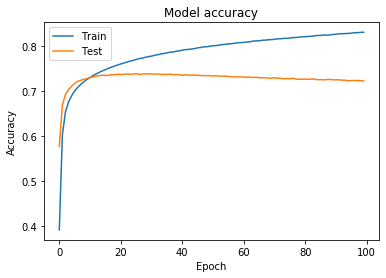

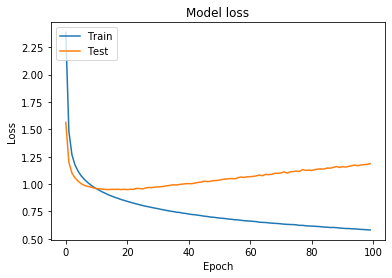

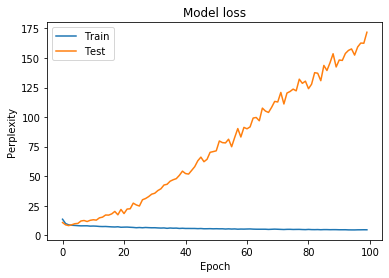

In [0]:
# snippet taken from https://keras.io/visualization/
import json
import matplotlib.pyplot as plt

met = open(OUTPUT_DIR+'/output_django.txt', 'r').read()

history = json.loads(met)

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['perplexity'])
plt.plot(history.history['val_perplexity'])
plt.title('Model loss')
plt.ylabel('Perplexity')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()